#AmeniDC
## See the cost of amenities in the District of Columbia

In [1]:
import simplejson as json
import requests
from requests import Request, Session
from bs4 import BeautifulSoup
import re

from urlparse import urljoin
from collections import namedtuple
import sqlite3
from pyspark.sql import SQLContext

import pandas as pd

#import geojson
#from geojson import Feature, Point, FeatureCollection
import pprint
pp = pprint.PrettyPrinter(indent=0)

#OpenData.DC API

Get the property sale points from http://opendata.dc.gov/datasets/2acc75ccdd954267acecb8713b2b800a_28
and store as a SQL database

In [9]:
from ediblepickle import checkpoint

@checkpoint(key='prop_sales_json.csv', work_dir='data', refresh=False)
def request_records():
  url = 'http://opendata.dc.gov/datasets/2acc75ccdd954267acecb8713b2b800a_28.geojson'
  with requests.Session() as s:
    resp = s.get(url)
    try:
        resp.raise_for_status()
    except requests.exceptions.HTTPError as e:
        print "And you get an HTTPError:", e.message
 

  return resp.json()

@checkpoint(key='prop_sales_dataframe.csv', work_dir='data', refresh=False)
def build_records(resp_json):
  row_dicts = []
  for feats in resp_json['features']:
    # Get all the property attributes
    row = feats['properties']
    row.update(feats['geometry'])
    row_dicts.append(row)
  return pd.DataFrame(row_dicts)


In [3]:
resp_json = request_records()

In [4]:
df = build_records(resp_json)
keep_cols = [u'ABTLOTCODE',
 u'ACCEPTCODE',
 u'ADDRESS1',
 u'ADDRESS2',
 u'ANNUALTAX',
 u'ASSESSMENT',
 u'BASEBUILD',
 u'BASELAND',
 u'CAPCURR',
 u'CAPPROP',
 u'CAREOFNAME',
 u'CITYSTZIP',
 u'CLASS3',
 u'CLASS3EX',
 u'CLASSTYPE',
 u'COOPUNITS',
 u'DELCODE',
 u'EXTRACTDAT',
 u'HIGHNUMBER',
 u'HSTDCODE',
 u'LANDAREA',
 u'LOT',
 u'LOWNUMBER',
 u'MIX1BLDPCT',
 u'MIX1BLDVAL',
 u'MIX1CLASS',
 u'MIX1LNDPCT',
 u'MIX1LNDVAL',
 u'MIX1RATE',
 u'MIX1TXTYPE',
 u'MIX2BLDPCT',
 u'MIX2BLDVAL',
 u'MIX2CLASS',
 u'MIX2LNDPCT',
 u'MIX2LNDVAL',
 u'MIX2RATE',
 u'MIX2TXTYPE',
 u'MIXEDUSE',
 u'NBHD',
 u'NEWIMPR',
 u'NEWLAND',
 u'NEWTOTAL',
 u'OBJECTID',
 u'OLDIMPR',
 u'OLDLAND',
 u'OLDTOTAL',
 u'OWNERNAME',
 u'OWNNAME2',
 u'OWNOCCT',
 u'PARTPART',
 u'PCHILDCODE',
 u'PHASEBUILD',
 u'PHASECYCLE',
 u'PHASELAND',
 u'PREMISEADD',
 u'PROPTYPE',
 u'QDRNTNAME',
 u'REASONCD',
 u'SALEDATE',
 u'SALEPRICE',
 u'SALETYPE',
 u'SQUARE',
 u'SSL',
 u'STREETCODE',
 u'STREETNAME',
 u'SUBNBHD',
 u'SUFFIX',
 u'TAXRATE',
 u'TRIGROUP',
 u'TXSALEDESC',
 u'UNITNUMBER',
 u'USECODE',
 u'VACLNDUSE',
 u'coordinates']

df.drop((c for c in df.columns.tolist() if c not in keep_cols),axis=1,inplace=True)
df['lat_lng'] = df['coordinates'].map(lambda row: str(row[1])+','+str(row[0]))
df['latitude'] = df['coordinates'].map(lambda row: row[1])
df['longitude'] = df['coordinates'].map(lambda row: row[0])
df.drop('coordinates',axis=1,inplace=True)
df

In [10]:
df.to_hdf('data/df_wo_goog.hd5','df')

# Google Maps Places API

Here, property sale locations are queried for nearby amenities. API requests were made once offline and pickled. Data for each lat_lng pair were stored as dict. 

Create a df column showing amenity_price_rating numbers for the top 20 hits within 1000m of the property

In [20]:
from query_google_places import get_all_amenities
df['amenities_1000'] = pd.Series(get_all_amenities())

In [38]:
df

,ABTLOTCODE,ACCEPTCODE,ADDRESS1,ADDRESS2,ANNUALTAX,ASSESSMENT,BASEBUILD,BASELAND,CAPCURR,CAPPROP,...,TAXRATE,TRIGROUP,TXSALEDESC,UNITNUMBER,USECODE,VACLNDUSE,lat_lng,latitude,longitude,amenities_1000
0,,MARKET,1010 MASSACHUSETTS AVE NW,,4170.26,560820,367850,157650,490620,530970,...,0.85,3,,607,017,N,"38.9030487951,-77.0267201832",38.903049,-77.026720,"{u'restaurant__price_2__rating_4.2': 1, u'rest..."
1,,MARKET,1010 MASSACHUSETTS AVE NW,,4766.96,560820,366100,156900,560820,601170,...,0.85,3,,606,017,N,"38.9030683973,-77.0267201905",38.903068,-77.026720,"{u'restaurant__price_2__rating_4.2': 1, u'rest..."
2,,MARKET,1010 MASSACHUSETTS AVE NW,,4170.26,560820,367150,157350,490620,530970,...,0.85,3,,508,017,N,"38.9032920901,-77.026715845",38.903292,-77.026716,"{u'restaurant__price_2__rating_4.2': 1, u'rest..."
3,,MARKET,1010 MASSACHUSETTS AVE NW,,6460.50,760060,553070,237030,760060,792390,...,0.85,3,,404,017,N,"38.9030568437,-77.0268117043",38.903057,-77.026812,"{u'restaurant__price_2__rating_4.2': 1, u'rest..."
4,,MARKET,1010 MASSACHUSETTS AVE NW,,4175.28,491210,290920,124680,491210,521860,...,0.85,3,,403,017,N,"38.903076446,-77.0268117117",38.903076,-77.026812,"{u'restaurant__price_2__rating_4.2': 1, u'rest..."
5,,MARKET,1010 MASSACHUSETTS AVE NW PH,,5010.06,589420,369600,158400,589420,631850,...,0.85,3,,402,017,N,"38.9030948951,-77.0268117186",38.903095,-77.026812,"{u'restaurant__price_2__rating_4.2': 1, u'rest..."
6,,MARKET,1111 ARMY NAVY DR APT 126,,3242.58,381480,261660,112140,381480,405190,...,0.85,3,,311,017,N,"38.9031698433,-77.0268132226",38.903170,-77.026813,"{u'restaurant__price_2__rating_4.2': 1, u'rest..."
7,,MARKET,1010 MASSACHUSETTS AVE NW,,2371.76,349230,229320,98280,279030,300680,...,0.85,3,,211,017,N,"38.9034131385,-77.0268162665",38.903413,-77.026816,"{u'restaurant__price_2__rating_4.2': 1, u'rest..."
8,,MARKET,700 N FAIRFAX ST STE 610,,4909.34,577570,385000,165000,577570,619170,...,0.85,3,,202,017,N,"38.9035688014,-77.0268148494",38.903569,-77.026815,"{u'restaurant__price_2__rating_4.2': 1, u'rest..."
9,,MARKET,503 D ST NW STE 100,,74808.00,4368000,3488870,1495230,4368000,4499040,...,0.00,3,,C-100,048,N,"38.9035730336,-77.0267711338",38.903573,-77.026771,"{u'restaurant__price_2__rating_4.2': 1, u'rest..."


Feed the new column into a DictVectorizer

In [28]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']
import matplotlib.pylab as plt

def grid_score_plotter(cv,param):
  cv_accuracy = pd.DataFrame.from_records(
      [(score.parameters[param],
        score.mean_validation_score)
       for score in cv.grid_scores_],
  columns=[param, 'accuracy'])

  plt.plot(cv_accuracy[param], cv_accuracy.accuracy)
  plt.xlabel(param)
  plt.ylabel('accuracy')
  plt.show()

In [36]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn import cross_validation, grid_search
import numpy as np


amen_pipe = Pipeline([
    ('vec', DictVectorizer(sparse=True)),
    ('ridge', linear_model.Ridge()),
])

amen_model = grid_search.GridSearchCV( amen_pipe,
                param_grid={'ridge__alpha':np.logspace(0.7,1.5,5)},
                cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                    test_size=0.2, random_state=42) )

amen_model.fit(df['amenities_1000'],df['SALEPRICE'])
grid_score_plotter(amen_model,'ridge__alpha')

GridSearchCV(cv=ShuffleSplit(18568, n_iter=20, test_size=0.2, random_state=42),
       error_score='raise',
       estimator=Pipeline(steps=[('vec', DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'ridge__alpha': array([  5.01187,   7.94328,  12.58925,  19.95262,  31.62278])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

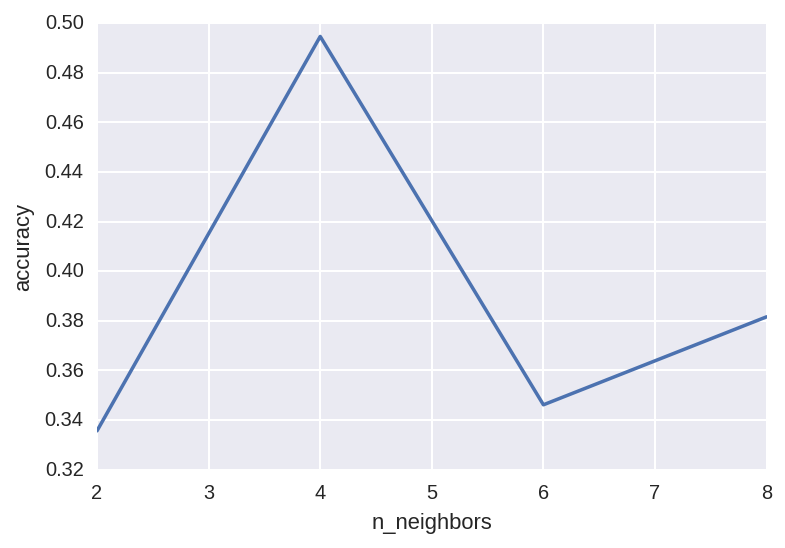

In [41]:
from sklearn import neighbors

lat_lng_model = grid_search.GridSearchCV( neighbors.KNeighborsRegressor(),
                param_grid={"n_neighbors": range(2,10,2)},
                cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                    test_size=0.2,) )

lat_lng_model.fit(df[['latitude','longitude']],df['SALEPRICE'])
grid_score_plotter(lat_lng_model,'n_neighbors')

#Google Distance Matrix API

Compute distances to subway stations

In [ ]:
# store results as list of dicts
results = resp_json['results'] 
Place = namedtuple('Place', ['place_id', 'name', 'lat','lng'], verbose=False)
stations = [Place(r['place_id'],r['name'],
                  r['geometry']['location']['lat'],
                  r['geometry']['location']['lng']) 
            for r in results]
for s in stations:
    print s.place_id, s.name, s.lat, s.lng


In [ ]:
search_url = "https://maps.googleapis.com/maps/api/distancematrix/json"
# Add this here because key must go last
search_url += '?origins='+str(base_lat)+','+str(base_lng)
search_url += '&destinations='+str(stations[0].lat)+','+str(stations[0].lng)

print search_url


In [ ]:
search_payload = {"key":key}
req = Request('GET', search_url,params=search_payload)
prepared = req.prepare()
print prepared.url

session = Session()
resp = session.send(prepared)
resp_json = resp.json()
print resp.status_code
print json.dumps(resp_json,indent=4, separators=(',', ': '))